In [1]:
%load_ext autoreload
%autoreload 2
from astropy.coordinates import Distance
import bilby
from gwBackground import *
import matplotlib.pyplot as plt
import numpy as np
import os
from pygwb.constants import H0
H0_si = H0.si.value
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
import sys
sys.path.append('../code/')
from tqdm import tqdm

In [2]:
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
# ALWAYS USE figsize = (3.375, X) for column plots 
# figsize = (6.75, X) for rows 
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
#    'text.usetex': True,
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]    

In [3]:
# Calculate the merger rate
def R(alpha, beta, z, z_p, R0):
    '''
    Equation from Callister et al. 2020.
    Calculates the merger rate at a given redshift.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z : double
        redshift
    z_p : double
        peak redshift of merger rate
    R0 : double
        current merger rate (z = 0)
        
    Returns
    -------
    double
        merger rate at the given redshift
    '''
    return (C(alpha, beta, z_p)*((R0*((1+z)**alpha))/(1+(((1+z)/(1+z_p))**(alpha+beta)))))

def C(alpha, beta, z_p):
    '''
    Equation from Callister et al. 2020.
    Calculates the normalization constant for the merger rate.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z_p : double
        peak redshift of merger rate
    
    Returns
    -------
    double
        normalization constant for the merger rate
    '''
    return (1+((1+z_p)**(-alpha-beta)))

def Hubble_rate(z, H0, omega_R, omega_M, omega_k, omega_lambda):
    '''
    Equation from Renzini et al. 2022.
    Calculates the Hubble rate as a function of redshift.
    
    Parameters
    ----------
    z : double
        redshift
    H0 : double
        Hubble constant (Hubble rate at z = 0)
    omega_R : double
        radiation component of energy density
    omega_M : double
        matter component of energy density
    omega_k : double
        spacetime curvature component of energy density
    omega_lambda : double
        dark energy component of energy density, cosmological constant
    
    Returns
    -------
    double
        Hubble rate for a given redshift z
    '''
    return H0*(((omega_R*((1+z)**4))+(omega_M*((1+z)**3))+(omega_k*((1+z)**2))+omega_lambda)**(1/2))

alpha = 1.9
beta = 3.4
z_p = 2.4
z_max = 10

R0 = 28.3 # current merger rate

dz = 0.01
zsMerger = np.arange(0.,z_max,dz)

mergerRate = []
for i in range(len(zsMerger)):
    mergerRate.append(R(alpha, beta, zsMerger[i], z_p, R0))
mergerRate = np.array(mergerRate)

In [4]:
# Define redshift prior
from bilby.gw.prior import Cosmological
class PowerLawRedshiftPrior(Cosmological):
    def __init__(self, minimum, maximum, R0, alpha, beta, zp, **kwargs):
        self.R0 = R0
        self.alpha = alpha
        self.beta = beta
        self.zp = zp
        super(PowerLawRedshiftPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)
        
    def _get_redshift_arrays(self):
        zs = np.linspace(self._minimum['redshift'] * 0.99,
                         self._maximum['redshift'] * 1.01, 1000)
        C = 1 + (1 + self.zp)**(-self.alpha - self.beta)
        p_dz = (1/(1+zs)) * C * ((self.R0 * (1 + zs)**(self.alpha))/(1 + ((1 + zs)/(1 + self.zp))**(self.alpha + self.beta))) * 4 * np.pi * self.cosmology.differential_comoving_volume(zs).value
        
        return zs, p_dz

14:47 bilby INFO    : Using aligned spin prior
14:47 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


Defining OmegaGW_BBH for max_mass = 38.9
[10.         10.30179131 10.61269042 10.93297219 11.26291979
 11.60282492 11.95298809 12.31371888 12.68533621 13.06816863
 13.4625546  13.8688428  14.28739242 14.71857351 15.16276726
 15.6203664  16.09177548 16.57741128 17.07770314 17.59309338
 18.12403765 18.67100535 19.23448007 19.81495996 20.41295822
 21.02900356 21.66364061 22.31743046 22.99095111 23.68479803
 24.39958465 25.13594291 25.89452382 26.67599804 27.48105647
 28.31041087 29.16479447 30.04496261 30.95169347 31.88578868
 32.84807407 33.83940039 34.86064408 35.91270802 36.99652234
 38.11304523 39.2632638  40.44819498 41.66888635 42.92641712
 44.22189908 45.55647756 46.93133245 48.34767928 49.80677021
 51.30989525 52.85838329 54.45360336 56.09696578 57.78992345
 59.53397311 61.33065667 63.18156258 65.08832723 67.05263637
 69.07622666 71.16088714 73.30846086 75.52084649 77.8       ]
[0.1285347  0.14215135 0.15576799 0.16938464 0.18300129
 0.19661793 0.21023458 0.22385122 0.23746787 0.2

14:50 bilby INFO    : Using aligned spin prior
14:50 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


Defining OmegaGW_BBH for max_mass = 41.45
[10.         10.31127535 10.63223994 10.96319537 11.30445262
 11.65633237 12.01916527 12.39329226 12.77906491 13.1768457
 13.58700843 14.00993852 14.44603338 14.8957028  15.35936931
 15.83746862 16.33044999 16.83877665 17.36292627 17.90339137
 18.46067982 19.03531529 19.62783774 20.23880395 20.86878804
 21.51838198 22.18819618 22.87886004 23.59102257 24.32535296
 25.08254124 25.86329893 26.66835969 27.49848    28.35443991
 29.23704374 30.14712086 31.08552643 32.05314226 33.05087758
 34.07966994 35.14048608 36.2343228  37.36220797 38.52520142
 39.724396   40.96091854 42.23593098 43.55063142 44.90625524
 46.3040763  47.74540807 49.23160495 50.76406348 52.34422367
 53.97357034 55.65363457 57.38599505 59.17227965 61.01416688
 62.91338752 64.87172622 66.89102318 68.97317587 71.12014085
 73.33393555 75.61664023 77.97039988 80.39742626 82.9       ]
[0.12062726 0.13436746 0.14810766 0.16184786 0.17558806
 0.18932826 0.20306846 0.21680866 0.23054885 0.2

14:53 bilby INFO    : Using aligned spin prior
14:53 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


Defining OmegaGW_BBH for max_mass = 44
[10.         10.32020097 10.65065481 10.99168981 11.34364479
 11.7068694  12.08172449 12.46858249 12.86782771 13.2798568
 13.70507911 14.14391707 14.59680667 15.06419784 15.54655492
 16.04435712 16.55809899 17.08829093 17.63545967 18.2001488
 18.78291933 19.38435024 20.00503902 20.64560231 21.3066765
 21.98891835 22.69300566 23.4196379  24.16953699 24.94344791
 25.74213953 26.56640534 27.41706423 28.29496129 29.2009687
 30.13598655 31.10094377 32.09679901 33.12454164 34.18519268
 35.27980587 36.40946869 37.57530341 38.77846828 40.0201586
 41.30160797 42.62408947 43.98891696 45.39744635 46.851077
 48.35125304 49.89946486 51.49725057 53.14619754 54.84794395
 56.60418045 58.41665181 60.28715868 62.21755936 64.20977165
 66.26577478 68.38761133 70.57738929 72.83728416 75.16954108
 77.57647709 80.06048342 82.62402788 85.26965729 88.        ]
[0.11363636 0.1274858  0.14133523 0.15518466 0.16903409
 0.18288352 0.19673295 0.21058239 0.22443182 0.23828125
 

14:56 bilby INFO    : Using aligned spin prior
14:56 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


Evaluated max_mass = 44
Finding maximum point.
Defining OmegaGW_BBH for max_mass = 48.6
[10.         10.33508383 10.68139579 11.03931209 11.4092216
 11.79152617 12.18664115 12.5949958  13.01703375 13.4532135
 13.90400894 14.36990981 14.85142225 15.34906941 15.86339191
 16.39494853 16.94431675 17.51209342 18.09889536 18.70536009
 19.33214646 19.97993544 20.64943078 21.34135983 22.0564743
 22.7955511  23.55939316 24.34883035 25.16472029 26.00794939
 26.87943373 27.7801201  28.71098702 29.67304579 30.66734158
 31.69495463 32.75700132 33.85463548 34.98904959 36.16147608
 37.37318869 38.62550383 39.91978203 41.25742939 42.63989916
 44.06869325 45.54536393 47.07151545 48.64880584 50.27894868
 51.96371498 53.70493507 55.50450063 57.36436672 59.28655392
 61.2731505  63.32631473 65.44827717 67.64134314 69.9078952
 72.25039577 74.67138974 77.1735073  79.75946678 82.43207758
 85.19424325 88.04896462 90.99934309 94.04858398 97.2       ]
[0.10288066 0.11689815 0.13091564 0.14493313 0.15895062
 0.17

15:03 bilby INFO    : Using aligned spin prior
15:03 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


Evaluated max_mass = 48.6
Finding maximum point.
Defining OmegaGW_BBH for max_mass = 53.2
[ 10.          10.3486384   10.70943166  11.08280357
  11.46919266  11.86905275  12.2828535   12.71108093
  13.15423802  13.61284527  14.08744132  14.57858361
  15.08684901  15.6128345   16.15715785  16.72045841
  17.30339779  17.90666068  18.53095562  19.17701588
  19.84560029  20.53749411  21.25351001  21.99448898
  22.76130131  23.55484767  24.3760601   25.22590315
  26.10537499  27.01550859  27.95737295  28.93207432
  29.94075751  30.98460728  32.06484966  33.18275343
  34.33963162  35.53684303  36.77579383  38.0579392
  39.38478509  40.75788992  42.17886645  43.64938368
  45.17116879  46.74600918  48.37575454  50.06231908
  51.80768374  53.61389852  55.48308488  57.41743825
  59.4192306   61.49081312  63.63461897  65.85316611
  68.14906033  70.52499824  72.98377046  75.52826492
  78.16147023  80.88647919  83.70649243  86.62482215
  89.64489605  92.77026132  96.00458883  99.35167741
 102.81545

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_1172/3032641515.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


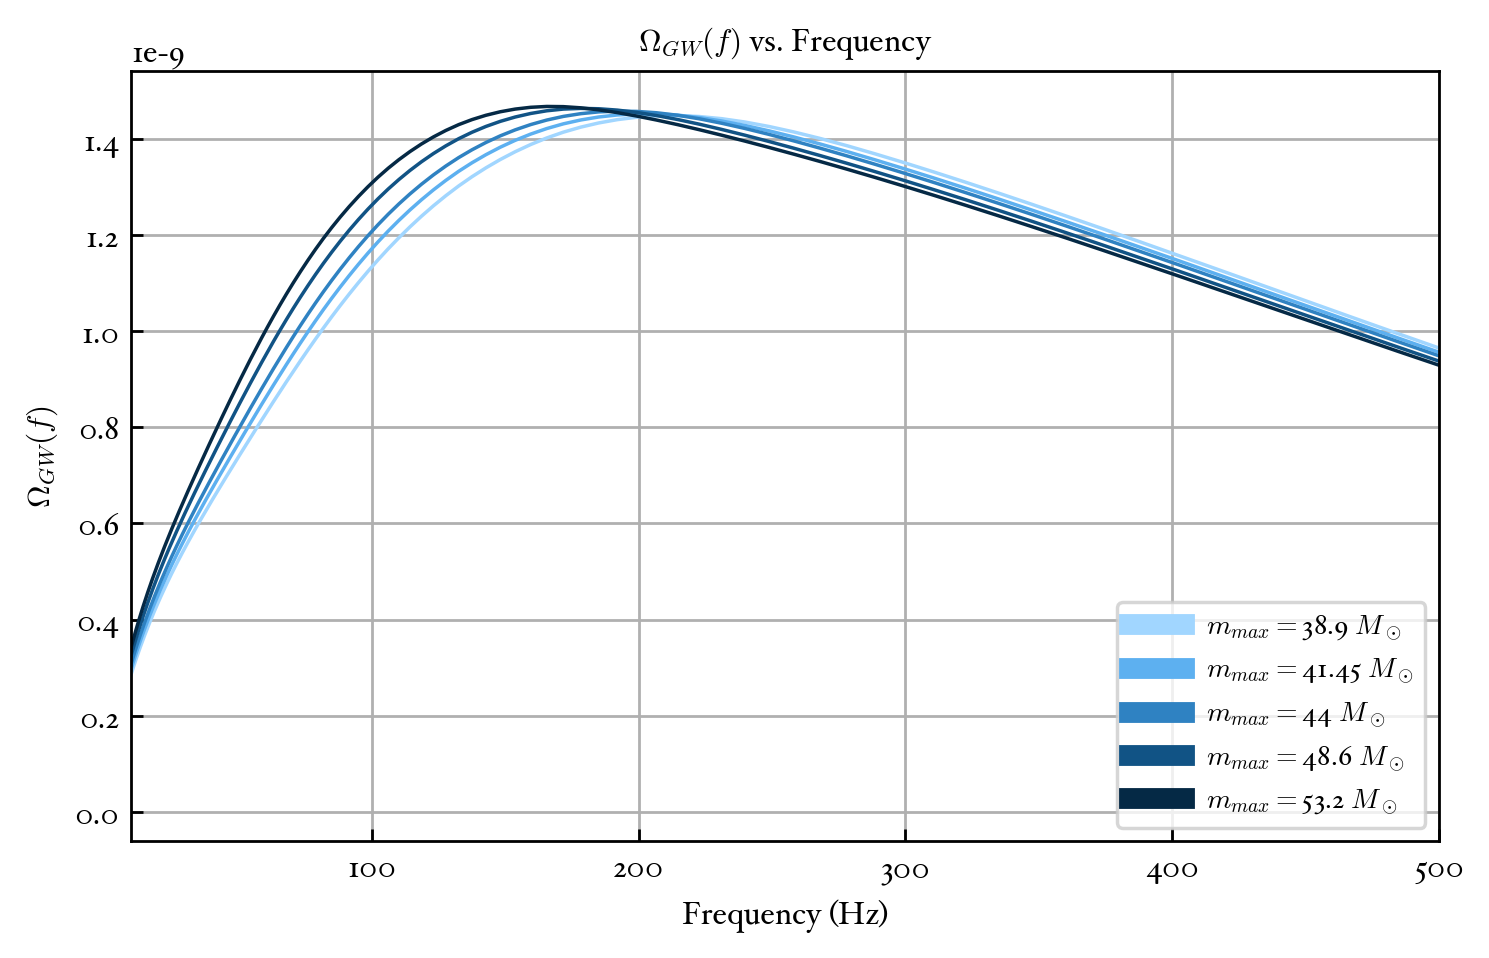

In [5]:
fig, ax = plt.subplots()
ax.set_title('$\Omega_{GW}(f)$ vs. Frequency')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 500)

omega_f_TCs = []
max_freqs_TC = []
max_omega_f_TC = []

max_mass_range = [38.9, 41.45, 44, 48.6, 53.2]
for max_mass in max_mass_range:
    m1_min = 5.                         # Minimum BH mass
    m1_max = max_mass                   # Maximum BH mass
    m2_min = 5.
    m2_max = max_mass
    fmax = 3000.                        # Maximum frequency we want to consider
    inspiralOnly=False                  # Include contributions from merger and ringdown
    minimum_component_mass = m2_min
    maximum_component_mass = m1_max
    
    # Define priors for the parameters in the Regimbau method
    priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
    # priors['chirp_mass'] = bilby.core.prior.Uniform(2, 30, name="chirp_mass")
    # priors['mass_ratio'] = 1.0
    # priors['mass_1'] = bilby.core.prior.LogUniform(5,m1_max)
    # priors['mass_2'] = bilby.core.prior.Uniform(5,m2_max)
    priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=5, maximum=max_mass)
    priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
    priors['chi_1'] = 0
    priors['chi_2'] = 0
    priors['theta_jn'] = bilby.core.prior.Uniform(0, 2*np.pi, name='theta_jn') # bilby.core.prior.Cosine()
    priors['redshift'] = PowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=z_p, name='redshift', minimum=0, maximum=10)

    print('Defining OmegaGW_BBH for max_mass = ' + str(max_mass))
    omg = OmegaGW_BBH(minimum_component_mass,maximum_component_mass,zsMerger)

    # Calculate probabilities based on the Regimbau method
    print('Calculating probability grid.')
    # Priors defined in (m1, m2) space
#     probs = np.empty((omg.m1s_2d.shape[0],omg.m2s_2d.shape[1])) # initialize array
#     for i in range(omg.m1s_2d.shape[0]): # for each m1
#         for j in range(omg.m2s_2d.shape[1]): # for each m2
#             prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_2':omg.m2s_2d[i][j]}) # calculate probability
#             probs[i][j] = prob # insert probability into probability array
#     probs = probs*(omg.Mtots_2d**2./(1.+omg.qs_2d)**2.) # multiply by the Jacobian
     
    # Priors defined in (m1, q) space
    probs = np.empty((omg.m1s_2d.shape[0],omg.qs_2d.shape[1])) # initialize array
    for i in range(omg.m1s_2d.shape[0]): # for each m1
        for j in range(omg.qs_2d.shape[1]): # for each m2
            prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
            probs[i][j] = prob # insert probability into probability array
    probs = probs*(omg.Mtots_2d/(1.+omg.qs_2d)) # multiply by the Jacobian

    # Now make sure that we're specifying physical masses for our BH and NS components
    probs[omg.m1s_2d<m1_min] = 0
    probs[omg.m1s_2d>m1_max] = 0
    probs[omg.m2s_2d<m2_min] = 0
    probs[omg.m2s_2d>m2_max] = 0

    # Finally, normalize the probabilities and give them to our OmegaGW calculator!
    probs /= np.sum(probs)
    omg.probs = probs

    freqs_TC = np.logspace(0,3.2,200)
    print('Evalating max_mass = ' + str(max_mass))
    omega_f = omg.eval(R0,mergerRate,freqs_TC)
    print('Evaluated max_mass = ' + str(max_mass))
    omega_f_TCs.append(omega_f)
    
    print('Finding maximum point.')
    max_omega_f_TC.append(max(omega_f))
    for i in range(len(omega_f)):
        if omega_f[i] == max(omega_f):
            max_freqs_TC.append(freqs_TC[i])
            
    if max_mass == max_mass_range[0]: 
        ax.plot(freqs_TC, omega_f, color='#a1d6ff', label=r'$m_{max}=$'+str(max_mass)+r' $M_\odot$')
    if max_mass == max_mass_range[1]: 
        ax.plot(freqs_TC, omega_f, color='#5db0f0', label=r'$m_{max}=$'+str(max_mass)+r' $M_\odot$')
    if max_mass == max_mass_range[2]: 
        ax.plot(freqs_TC, omega_f, color='#2f82c2', label=r'$m_{max}=$'+str(max_mass)+r' $M_\odot$')
    if max_mass == max_mass_range[3]: 
        ax.plot(freqs_TC, omega_f, color='#115385', label=r'$m_{max}=$'+str(max_mass)+r' $M_\odot$')
    if max_mass == max_mass_range[4]: 
        ax.plot(freqs_TC, omega_f, color='#052945', label=r'$m_{max}=$'+str(max_mass)+r' $M_\odot$')

ax.legend()
fig.show()

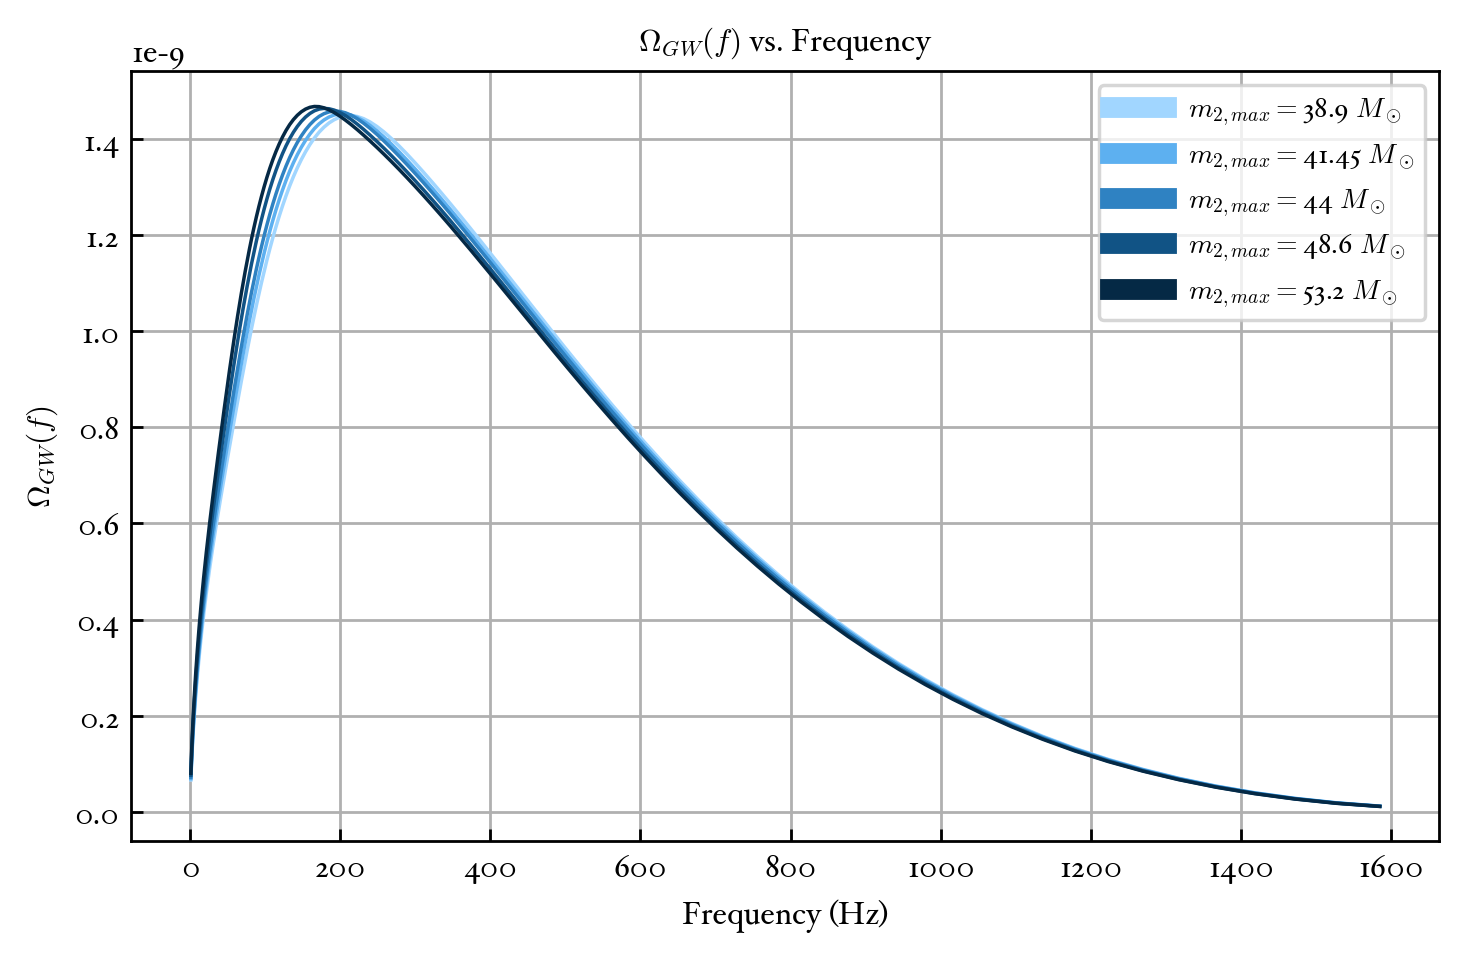

In [6]:
fig, ax = plt.subplots()
ax.set_title('$\Omega_{GW}(f)$ vs. Frequency')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.plot(freqs_TC, omega_f_TCs[0], color='#a1d6ff', label=r'$m_{2, max}=$'+str(max_mass_range[0])+r' $M_\odot$')
ax.plot(freqs_TC, omega_f_TCs[1], color='#5db0f0', label=r'$m_{2, max}=$'+str(max_mass_range[1])+r' $M_\odot$')
ax.plot(freqs_TC, omega_f_TCs[2], color='#2f82c2', label=r'$m_{2, max}=$'+str(max_mass_range[2])+r' $M_\odot$')
ax.plot(freqs_TC, omega_f_TCs[3], color='#115385', label=r'$m_{2, max}=$'+str(max_mass_range[3])+r' $M_\odot$')
ax.plot(freqs_TC, omega_f_TCs[4], color='#052945', label=r'$m_{2, max}=$'+str(max_mass_range[4])+r' $M_\odot$')
ax.legend()

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_1172/1691317028.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


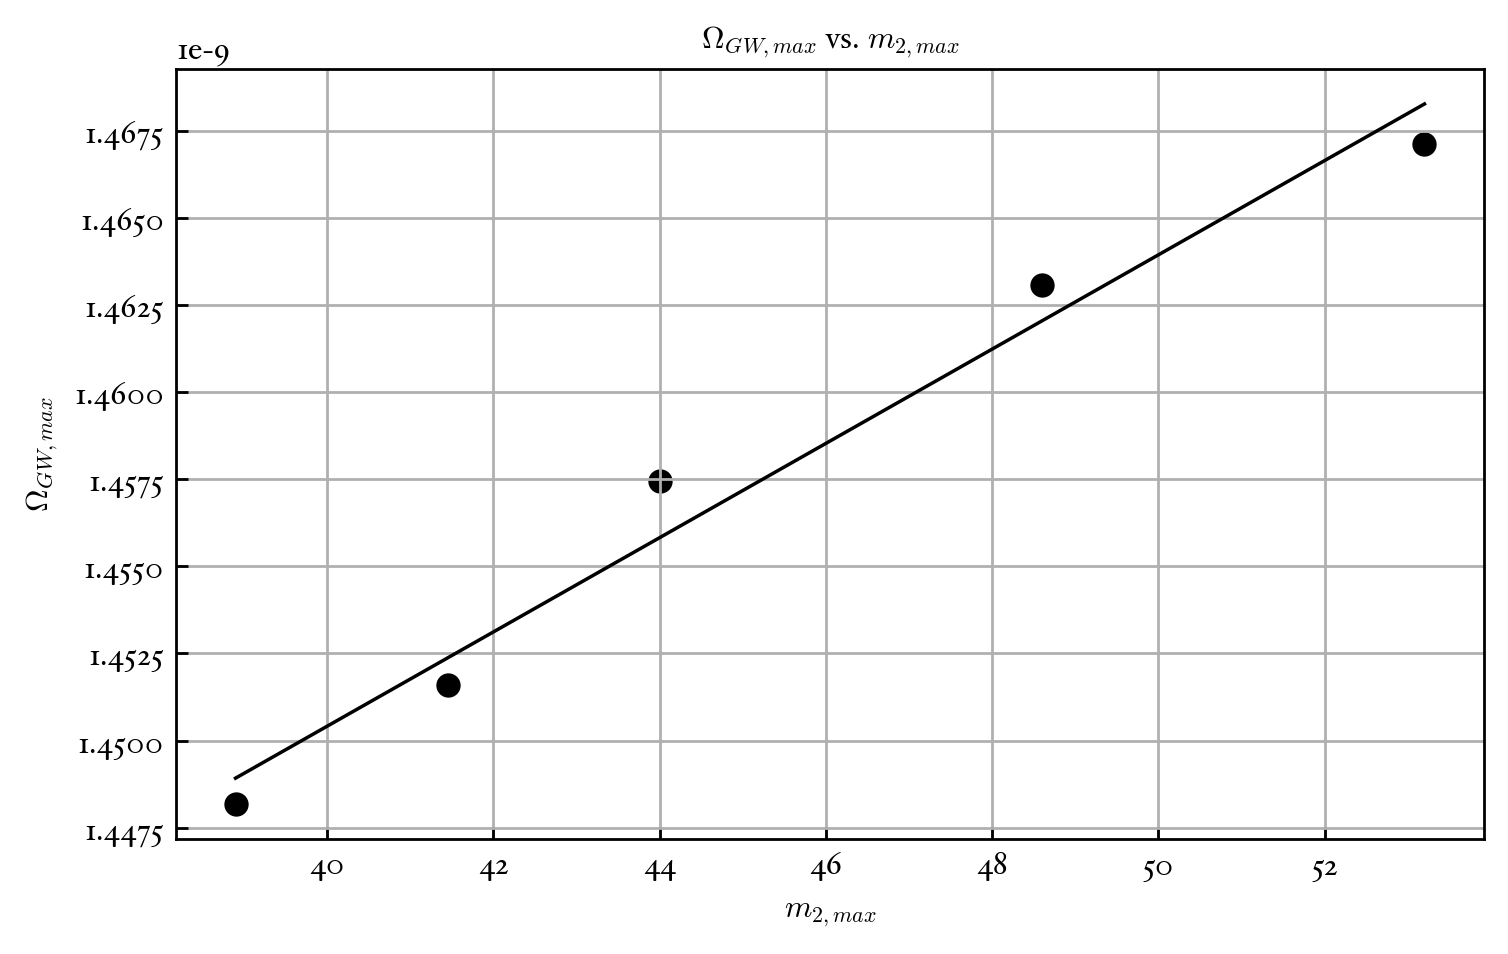

In [7]:
fig, ax = plt.subplots()
ax.set_title(r'$\Omega_{GW, max}$ vs. $m_{2, max}$')
ax.set_xlabel(r'$m_{2, max}$')
ax.set_ylabel(r'$\Omega_{GW, max}$')
ax.scatter(max_mass_range, max_omega_f_TC, color='#000000')
a, b = np.polyfit(max_mass_range, max_omega_f_TC, 1)
omegaGW_max = []
for i in range(len(max_mass_range)):
    omegaGW_max.append(a*max_mass_range[i]+b)
ax.plot(max_mass_range, omegaGW_max, color='#000000')

fig.show()

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_1172/3964953199.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


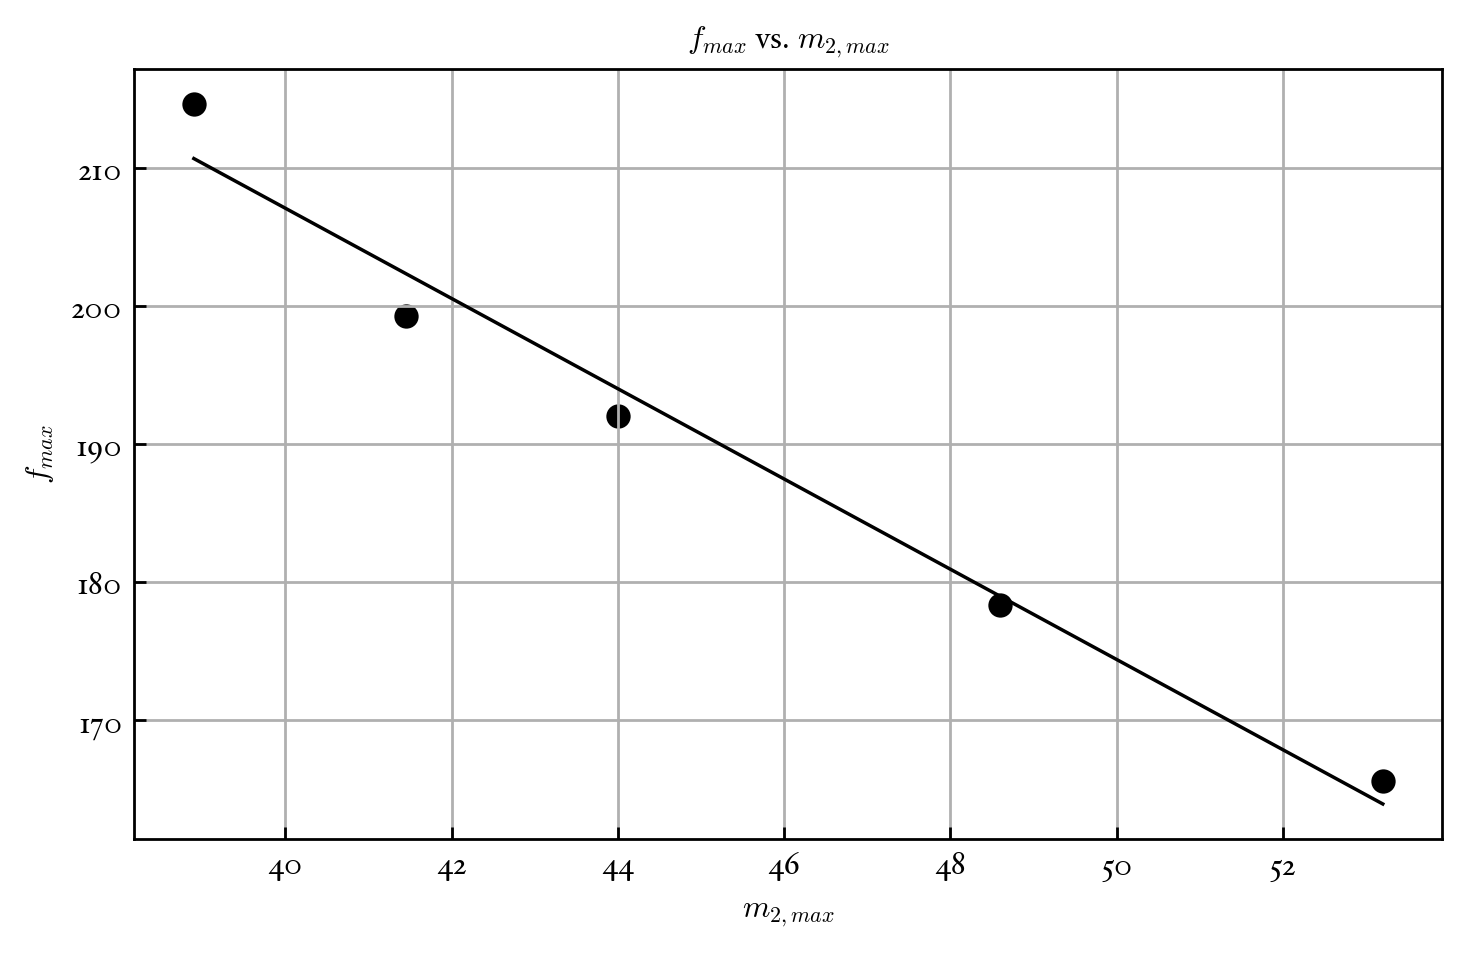

In [8]:
fig, ax = plt.subplots()
ax.set_title(r'$f_{max}$ vs. $m_{2, max}$')
ax.set_xlabel(r'$m_{2, max}$')
ax.set_ylabel(r'$f_{max}$')
ax.scatter(max_mass_range, max_freqs_TC, color='#000000')
a, b = np.polyfit(max_mass_range, max_freqs_TC, 1)
f_max = []
for i in range(len(max_mass_range)):
    f_max.append(a*max_mass_range[i]+b)
ax.plot(max_mass_range, f_max, color='#000000')
# ax.text(r'$f_{max}$ = ' + '{:.2f}'.format(a) + r'$m_{2,max}$' + ' + {:.2f}'.format(b))
fig.show()